# COMP47590: Advanced Machine Learning
# Assignment 1: Implementing Gradient Boosting - SOLUTION

- Student 1 Name:   Fangyijie Wang
- Student 1 Number: 13204942

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import sklearn
import sklearn.utils
import sklearn.model_selection
import sklearn.base 
import sklearn.utils.validation 
import sklearn.preprocessing
import sklearn.metrics

## Task 1: The GradientBoosting Regressor

Define the GradientBoostingRegressor class

In [2]:
import sklearn.tree
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and RegressorMixin classes
class GradientBoostingRegressor(BaseEstimator, RegressorMixin):
    """GradientBoostingRegressor only works for continuous descriptive features and continuous target features.  
        - Training: Train the new model to add to the ensemble by training the model to predict the errors (in regression terms the residuals) of the old model.
        - Prediction: When a new prediction needs to be made compare the descriptive feature values of the new query instance to each tree and return the target feature that is close to the query case. 

    Parameters
    ----------
    num_base_estimators numeric, required (default = 1) 
        The number of estimators to include in the model.

    Attributes
    ----------
    trees_: dict
        A dictionary of the DecisionTree on all descriptive features in each epoch.
        
    Notes
    -----
    

    See also
    --------
    
    ----------
    
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> reg = GradientBoostingRegressor()
    >>> iris = load_iris()
    >>> cross_val_score(reg, iris.data, iris.target, cv=10)
    """
    # Constructor for the regressor object
    def __init__(self, 
                 num_base_estimators, # the number of base estimators to include
                 tree_depth=6,  # the depth of decision tree
                 min_samples_leaf=3, # the mini number of samples required to be at a leaf node
                 random_state=None
                ):
        self.num_base_estimators = num_base_estimators
        self.tree_depth = tree_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build an educated guess regressor from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """
        
        # change instance from array to 2D matrix
        X = np.asmatrix(X)      
        y = np.array(y)       
            
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Set up the random number generator to be used to generate 
        # predictions - this follows reccommended scikitlearn pattern
        # https://scikit-learn.org/stable/developers/develop.html#coding-guidelines
        self.random_state_ = check_random_state(self.random_state)
        
        self.trees_ = []
        
        self.m0 = y.mean()
        M = self.m0
        
        for i in range(self.num_base_estimators):
            # compute residuals
            res = y - self.m0
            # fit DecisionTree on X and residuals
            tree = sklearn.tree.DecisionTreeRegressor(max_depth=self.tree_depth,
                                                      min_samples_leaf=self.min_samples_leaf,
                                                      random_state=self.random_state)
            tree.fit(X, res)
            delta = tree.predict(X)
            # add delta to the model M 
            M = M + delta
            # append the tree
            self.trees_.append(tree)
            
        # Return the regressor
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict continues value of the input samples X.
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the trees_ dictionary has been set up
        check_is_fitted(self, ['trees_'])
        
        # change instance from array to 2D matrix
        X = np.asmatrix(X)             

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        M = self.m0
        
        for i in range(self.num_base_estimators):
            # use trees to predict target feature
            M = M + self.trees_[i].predict(X)
            
        return M

## Task 2: Evaluation

Set up some dictionaries to store simple model performance comparions.

In [4]:
model_valid_MAE_comparisons = dict()
model_MAE_comparisons = dict()
model_tuned_params_list = dict()
cvfolds = 10
# use Mean Absolute Error (MAE) as the evaluation metric
scoring = 'neg_mean_absolute_error'

### Load the Readability Dataset

In [5]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200) 
pd.set_option('display.max_colwidth', 100)
import numpy as np

In [6]:
bag_of_words_file = 'commonlitreadabilityprize_bow.csv'
embedding_file = 'commonlitreadabilityprize_embedding.csv'

In [7]:
bow_training_data = pd.read_csv(bag_of_words_file)
print(bow_training_data.shape)
display(bow_training_data.head())

(2834, 1829)


,Unnamed: 0,$,ability,able,absolutely,accompanied,accomplished,according,account,acid,act,action,active,activity,acts,actual,actually,added,addition,admiration,advanced,advantage,affairs,afraid,africa,afternoon,afterward,age,ages,ago,agreed,ah,ahead,aid,air,alice,allow,allowed,allows,america,american,americans,ancient,angry,animal,animals,answer,answered,anxious,apart,...,window,windows,winds,wing,wings,winter,wire,wise,wish,wished,wo,woke,woman,women,won,wonder,wondered,wonderful,wood,wooden,woods,word,words,wore,work,worked,working,works,world,worn,worried,worse,worth,write,writing,written,wrong,wrote,yard,yards,year,years,yellow,yes,york,young,youth,°,id,target
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,c12129c31,-0.340259
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85aa80a4c,-0.315372
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b69ac6792,-0.580118
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,dd1000b26,-1.054013
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37c1b32fb,0.247197


In [8]:
print("Missing Values")
print(bow_training_data.isnull().sum().sort_values(ascending = False))

Missing Values
Unnamed: 0    0
produce       0
process       0
problems      0
problem       0
             ..
follows       0
following     0
followed      0
follow        0
target        0
Length: 1829, dtype: int64


In [9]:
emb_training_data = pd.read_csv(embedding_file)
print(emb_training_data.shape)
display(emb_training_data.head())

(2834, 303)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,id,target
0,0,0.054942,0.104693,-0.129839,-0.077362,0.066479,-0.007780,-0.010820,-0.054412,-0.069162,2.085748,-0.060080,0.040206,0.078970,-0.092061,-0.113453,-0.105683,-0.018003,1.089996,-0.157291,-0.049872,-0.038974,-0.044448,-0.051416,0.072666,0.006214,-0.023308,-0.103280,-0.000791,-0.035179,-0.041778,-0.010981,0.052993,-0.096132,0.057582,0.072257,-0.147485,-0.058766,-0.006197,-0.030359,-0.055719,0.029750,0.133593,0.007728,-0.103093,0.096608,0.020460,-0.124611,-0.101497,0.044355,...,0.009718,-0.022423,0.052422,0.258125,0.172970,0.005742,-0.068247,0.043332,0.175139,0.131109,-0.030145,0.030684,0.077186,-0.009650,-0.001977,-0.019755,0.067259,-0.036809,-0.027976,-0.018284,-0.074472,-0.165668,-0.128944,-0.001251,0.025481,0.116750,-0.038316,0.141899,0.243866,0.032853,-0.060356,-0.101602,-0.050094,-0.060763,0.114494,-0.052732,0.121442,-0.079718,-0.238603,0.031822,0.059434,-0.093304,-0.134071,0.053603,0.038264,-0.028437,-0.022459,0.068514,c12129c31,-0.340259
1,1,-0.014731,0.213879,-0.183907,-0.048958,0.112992,0.026316,0.028143,-0.137892,-0.094396,2.170374,-0.155052,0.084018,0.093432,-0.090761,-0.184210,-0.045192,-0.100942,0.870650,-0.183582,0.022500,-0.002261,-0.022219,-0.042072,-0.042623,-0.055870,0.029976,-0.014145,-0.076327,0.112394,-0.168088,-0.052931,0.045638,-0.100293,0.127503,0.101659,-0.109052,-0.011360,0.030617,-0.090257,-0.035377,-0.006508,-0.010191,-0.032645,-0.120629,0.083803,0.067324,-0.196460,-0.060567,0.115225,...,-0.112212,-0.036007,0.033733,0.198936,0.076721,-0.052154,-0.087582,0.107428,0.068410,0.107855,-0.000844,0.111956,0.051873,0.002043,-0.014444,0.032021,0.122599,0.021301,-0.031341,-0.088206,-0.100880,-0.094794,-0.113471,0.018583,-0.000031,0.077720,0.028152,0.201130,0.212862,0.003240,0.066036,-0.129031,-0.026765,-0.049921,0.120074,-0.079767,0.147799,0.018992,-0.105756,0.051830,0.006578,-0.007093,0.065427,-0.029093,-0.000948,0.012834,0.015731,0.002224,85aa80a4c,-0.315372
2,2,-0.006671,0.217069,-0.125178,-0.073087,0.106584,0.016715,0.011751,-0.115226,-0.071845,2.141033,-0.135347,0.044908,0.057914,-0.058195,-0.149449,-0.053666,-0.026909,0.822324,-0.158412,-0.001502,-0.007176,-0.028327,-0.014629,-0.048186,0.021881,0.019163,-0.091954,-0.019096,0.069852,-0.100524,-0.051520,0.076176,-0.067022,0.044913,0.044163,-0.114472,-0.039097,0.025448,-0.076740,-0.006505,-0.006603,0.046618,0.017113,-0.098088,0.080918,0.063744,-0.212404,-0.022673,0.051141,...,-0.064818,-0.047286,0.058058,0.155161,0.062122,-0.060407,-0.057822,0.058438,0.152636,0.142695,0.001692,0.106070,0.059557,-0.014198,-0.027812,-0.003158,0.136810,0.004483,0.043852,-0.073878,-0.047607,-0.103589,-0.124074,0.015846,0.018385,0.057015,-0.003170,0.170545,0.187558,0.017306,-0.009738,-0.094571,-0.017686,-0.045320,0.086171,-0.079157,0.120796,-0.057970,-0.116192,0.020743,0.012045,-0.028818,0.044761,-0.033804,0.015294,-0.019791,0.020420,0.016437,b69ac6792,-0.580118
3,3,0.040802,0.123908,-0.106365,-0.109637,0.090377,0.020302,-0.004274,-0.007752,-0.103293,2.044155,-0.114577,0.053231,-0.004328,-0.138667,-0.142876,-0.056131,-0.052775,0.946257,-0.108830,-0.033371,0.017975,0.036760,-0.107292,0.045815,-0.012851,-0.082862,-0.054655,0.042623,-0.008409,-0.040737,-0.051928,0.110341,-0.107192,0.056082,0.109184,-0.118366,-0.025728,-0.035033,-0.067925,0.029779,-0.050414,0.064762,0.012224,-0.119392,0.147026,0.033925,-0.105274,-0.068832,0.058932,...,-0.029999,-0.057206,0.086667,0.267056,0.201220,-0.019701,-0.091312,0.085022,0.129807,0.108902,-0.002623,0.118156,0.087849,-0.070147,-0.043028,-0.082752,-0.061191,-0.065372,0.000285,-0.036547,-0.018116,-0.131600,-0.127061,0.053523,0.026109,0.114862,-0.014734,0.143633,0.312614,0.014281,0.006405,-0.085322,-0

In [10]:
print("Missing Values")
print(emb_training_data.isnull().sum().sort_values(ascending = False))

Missing Values
Unnamed: 0    0
207           0
205           0
204           0
203           0
             ..
99            0
98            0
97            0
96            0
target        0
Length: 303, dtype: int64


In [11]:
target_feature_name = 'target'

In [12]:
emb_X = emb_training_data.iloc[:, 1:-2]  # exclude the target label
emb_y = emb_training_data[target_feature_name]

In [13]:
bow_X = bow_training_data.iloc[:, 1:-2]  # exclude the target label
bow_y = bow_training_data[target_feature_name]

Choose the baseline model.

In [14]:
from sklearn import linear_model

In [15]:
# choose the Linear Regressor model as baseline
baseline = linear_model.Ridge()

### Gradient Boosting Model Evaluation

Evaluate the performance of the Gradient Boosting Regressor on the daibetic retinopathy dataset.

In [16]:
custom_gbr = GradientBoostingRegressor(num_base_estimators=10)

In [17]:
# evaluate the Gradient Boosting Regressor model on bag of words
bow_gbr_scores = sklearn.model_selection.cross_val_score(custom_gbr, 
                                                         bow_X, bow_y, 
                                                         cv=cvfolds, 
                                                         scoring=scoring)

In [18]:
bow_gbr_scores = abs(bow_gbr_scores)
print('GBRegressor on bow - Mean MAE: %.3f (%.3f)' % (np.mean(bow_gbr_scores), np.std(bow_gbr_scores)))

GBRegressor on bow - Mean MAE: 3.768 (0.444)


In [19]:
model_valid_MAE_comparisons["bow GBR"] = bow_gbr_scores

In [20]:
# evaluate the Gradient Boosting Regressor model on the sentence embedding
emb_gbr_scores = sklearn.model_selection.cross_val_score(custom_gbr, 
                                                         emb_X, emb_y, 
                                                         cv=cvfolds, 
                                                         scoring=scoring)

In [21]:
emb_gbr_scores = abs(emb_gbr_scores)
print('GBRegressor on emb - Mean MAE: %.3f (%.3f)' % (np.mean(emb_gbr_scores), np.std(emb_gbr_scores)))

GBRegressor on emb - Mean MAE: 6.108 (0.569)


In [22]:
model_valid_MAE_comparisons["emb GBR"] = emb_gbr_scores

### Scikit-learn Model Performance
Evaluate the performance of the a scitkit-learn classifier on the daibetic retinopathy dataset.

In [23]:
# evaluate the baseline model on bag of words 
bow_lr_scores = sklearn.model_selection.cross_val_score(baseline, 
                                                        bow_X, bow_y, 
                                                        cv=cvfolds,
                                                        scoring=scoring)

In [24]:
bow_lr_scores = abs(bow_lr_scores)
print('LR on bow - Mean MAE: %.3f (%.3f)' % (np.mean(bow_lr_scores), np.std(bow_lr_scores)))

LR on bow - Mean MAE: 1.002 (0.080)


In [25]:
model_valid_MAE_comparisons["bow LR"] = bow_lr_scores

In [26]:
# evaluate the baseline model on the sentence embedding
emb_lr_scores = sklearn.model_selection.cross_val_score(baseline, 
                                                        emb_X, emb_y, 
                                                        cv=cvfolds,
                                                        scoring=scoring)

In [27]:
emb_lr_scores = abs(emb_lr_scores)
print('LR on emb - Mean MAE: %.3f (%.3f)' % (np.mean(emb_lr_scores), np.std(emb_lr_scores)))

LR on emb - Mean MAE: 0.520 (0.033)


In [28]:
model_valid_MAE_comparisons["emb LR"] = emb_lr_scores

In [29]:
model_valid_MAE_comparisons

{'bow GBR': array([4.34696223, 3.18482859, 4.06903052, 4.39532793, 3.81900575,
        3.00173781, 3.35470114, 3.98642622, 3.709359  , 3.81361068]),
 'emb GBR': array([5.70824729, 6.67430322, 6.75975891, 7.05294587, 5.28773622,
        5.44939101, 6.10033111, 6.19543117, 5.57079057, 6.28374336]),
 'bow LR': array([0.92873792, 1.16294704, 1.11475476, 1.05930874, 0.93260204,
        1.0155717 , 0.94830568, 0.94927368, 0.92274169, 0.98596119]),
 'emb LR': array([0.47135247, 0.54498432, 0.54024715, 0.56341597, 0.49526877,
        0.51649491, 0.53640514, 0.55057306, 0.45972306, 0.52572064])}

Compare the Mean Absolute Error by plotting.

In [30]:
import matplotlib.pyplot as plot 

In [31]:
MAE_df = pd.DataFrame.from_dict(model_valid_MAE_comparisons)

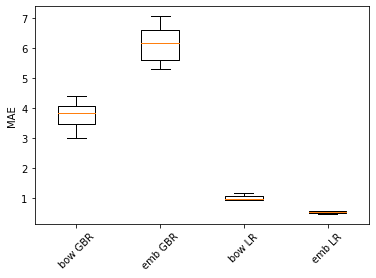

In [32]:
# Making a plot
bp = plot.boxplot(MAE_df) 

plot.ylabel('MAE')
plot.xticks([1, 2, 3, 4],
           MAE_df.columns,
           rotation=45)
# display the plot
plot.show()

The above boxplot indicates that the smallest Mean Absolute Error (MAE) was achieved by training the **Linear Regressor (LR) model** on the sentence embedding (emb) representation. It means that Linear Regressor performs better than our Gradient Boosting Regressor on the CommonLit Readability Prize dataset. The Gradient Boosting Regressor (GBR) achieved **smaller MAE on the bag of words representation** than the sentence embedding representation.

## Task 3 & 4: Add Subsampling and Learning Rate

Re-implement the GradientBoostingRegressor class adding subsampling and a learning rate as options. 

In [33]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and RegressorMixin classes
class GradientBoostingRegressor(BaseEstimator, RegressorMixin):
    """GradientBoostingRegressor only works for continuous descriptive features and continuous target features.  
        - Training: Train the new model to add to the ensemble by training the model to predict the errors (in regression terms the residuals) of the old model.
        - Prediction: When a new prediction needs to be made compare the descriptive feature values of the new query instance to each tree and return the target feature that is close to the query case. 

    Parameters
    ----------
    num_base_estimators numeric, required (default = 1) 
        The number of estimators to include in the model.
    subsampling_of_rows boolean, optional (default = False)
        Used to train each base estimator to be turned on or off.
    learning_rate numeric, optional (default = 0)
        Reduces the influence of models trained later in the ensemble building process.

    Attributes
    ----------
    trees_: dict
        A dictionary of the DecisionTree on all descriptive features in each epoch.
        
    Notes
    -----
    

    See also
    --------
    
    ----------
    
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> reg = GradientBoostingRegressor()
    >>> iris = load_iris()
    >>> cross_val_score(reg, iris.data, iris.target, cv=10)
    """
    # Constructor for the regressor object
    def __init__(self, 
                 num_base_estimators = 5,
                 subsampling_of_rows = False, 
                 subsampling_ratio = 0.5, # percentage of rows used per tree building
                 learning_rate = 1e-3, # default learning rate
                 tree_depth=6,  # the depth of decision tree
                 min_samples_leaf=3, # the mini number of samples required to be at a leaf node
                 random_state=None
                ):
        self.num_base_estimators = num_base_estimators
        self.subsampling_of_rows = subsampling_of_rows
        self.subsampling_ratio = subsampling_ratio
        self.learning_rate = learning_rate
        self.tree_depth = tree_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build an educated guess regressor from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """       
            
        # change instance from array to 2D matrix
        X = np.matrix(X)      
        y = np.array(y)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Set up the random number generator to be used to generate 
        # predictions - this follows reccommended scikitlearn pattern
        # https://scikit-learn.org/stable/developers/develop.html#coding-guidelines
        self.random_state_ = check_random_state(self.random_state)    
        
        if self.subsampling_of_rows:
            # select the random size of subsampling
            #rand_size = np.random.randint(1, X.shape[0])
            rand_size = int(X.shape[0] * self.subsampling_ratio)
            # select the index of rows randomly
            rand_idx = np.random.choice(X.shape[0], rand_size, replace=False)
            # select the subset of X and y respectively
            X = X[rand_idx,:]
            y = y[rand_idx]     
        
        # store all generated trees
        self.trees_ = []
        
        self.m0 = y.mean()
        M = self.m0        
        
        for i in range(self.num_base_estimators):
            # compute residuals
            res = y - self.m0
            # fit DecisionTree on X and residuals
            tree = sklearn.tree.DecisionTreeRegressor(max_depth=self.tree_depth,
                                                      min_samples_leaf=self.min_samples_leaf,
                                                      random_state=self.random_state)
            tree.fit(X, res)
            delta = tree.predict(X)
            # add delta to the model M 
            M = M + self.learning_rate * delta
            # append the tree
            self.trees_.append(tree)
            
        # Return the regressor
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict continues value of the input samples X.
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        M : array of shape = [n_samples, ].
            The predicted values of the input samples. 
        """
        
        # Check is fit had been called by confirming that the trees_ dictionary has been set up
        check_is_fitted(self, ['trees_'])
        
        # change instance from array to 2D matrix
        X = np.matrix(X)             

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        M = self.m0
        
        for i in range(self.num_base_estimators):
            # use trees to predict target feature
            M = M + self.learning_rate * self.trees_[i].predict(X)
            
        return M

## Task 5: Hyperparameter Tuning

Perform hyper-parameter tuning and evaluate models. 

In [34]:
# Set up the parameter grid to seaerch
param_grid ={
    'num_base_estimators': [5, 10, 15, 20],
    'subsampling_of_rows': [True, False], 
    'learning_rate': [1e-3, 1e-2, 1e-1]
}
cvfolds = 5

In [35]:
# Perform the search
emb_tuned_gbr = sklearn.model_selection.GridSearchCV(GradientBoostingRegressor(),
                                                    param_grid, cv = cvfolds, 
                                                    scoring = scoring, verbose = 2,
                                                    return_train_score = True, n_jobs = -1)

* Do hyperparameter tuning on the sentence embedding representation dataset with 5 folds cross-validation.

In [36]:
emb_tuned_gbr.fit(emb_X, emb_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'num_base_estimators': [5, 10, 15, 20],
                         'subsampling_of_rows': [True, False]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

In [37]:
# Print details
print("Best parameters set found on development set:")
print(emb_tuned_gbr.best_params_)
model_tuned_params_list["Tuned GBR emb"] = emb_tuned_gbr.best_params_
print(abs(emb_tuned_gbr.best_score_))
model_valid_MAE_comparisons["Tuned GBR emb"] = abs(emb_tuned_gbr.cv_results_['mean_test_score'])

Best parameters set found on development set:
{'learning_rate': 0.1, 'num_base_estimators': 10, 'subsampling_of_rows': False}
0.7127351010962902


* Do hyperparameter tuning on the bag of words representation dataset with 5 folds cross-validation.

In [38]:
# Perform the search
bow_tuned_gbr = sklearn.model_selection.GridSearchCV(GradientBoostingRegressor(),
                                                    param_grid, cv = cvfolds, 
                                                    scoring = scoring, verbose = 2,
                                                    return_train_score = True, n_jobs = -1)

In [39]:
bow_tuned_gbr.fit(bow_X, bow_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

[CV] END learning_rate=0.001, num_base_estimators=5, subsampling_of_rows=True; total time=   0.7s
[CV] END learning_rate=0.001, num_base_estimators=10, subsampling_of_rows=True; total time=   1.4s
[CV] END learning_rate=0.001, num_base_estimators=10, subsampling_of_rows=False; total time=   3.0s
[CV] END learning_rate=0.001, num_base_estimators=15, subsampling_of_rows=False; total time=   4.7s
[CV] END learning_rate=0.001, num_base_estimators=20, subsampling_of_rows=False; total time=   6.0s
[CV] END learning_rate=0.01, num_base_estimators=10, subsampling_of_rows=False; total time=   3.0s
[CV] END learning_rate=0.01, num_base_estimators=15, subsampling_of_rows=True; total time=   2.1s
[CV] END learning_rate=0.01, num_base_estimators=20, subsampling_of_rows=True; total time=   2.8s
[CV] END learning_rate=0.01, num_base_estimators=20, subsampling_of_rows=False; total time=   6.2s
[CV] END learning_rate=0.1, num_base_estimators=10, subsampling_of_rows=False; total time=   3.0s
[CV] END le

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'num_base_estimators': [5, 10, 15, 20],
                         'subsampling_of_rows': [True, False]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

In [40]:
# Print details
print("Best parameters set found on development set:")
print(bow_tuned_gbr.best_params_)
model_tuned_params_list["Tuned GBR bow"] = bow_tuned_gbr.best_params_
print(abs(bow_tuned_gbr.best_score_))
model_valid_MAE_comparisons["Tuned GBR bow"] = abs(bow_tuned_gbr.cv_results_['mean_test_score'])

Best parameters set found on development set:
{'learning_rate': 0.1, 'num_base_estimators': 5, 'subsampling_of_rows': False}
0.8342206171824735


In [41]:
model_valid_MAE_comparisons

{'bow GBR': array([4.34696223, 3.18482859, 4.06903052, 4.39532793, 3.81900575,
        3.00173781, 3.35470114, 3.98642622, 3.709359  , 3.81361068]),
 'emb GBR': array([5.70824729, 6.67430322, 6.75975891, 7.05294587, 5.28773622,
        5.44939101, 6.10033111, 6.19543117, 5.57079057, 6.28374336]),
 'bow LR': array([0.92873792, 1.16294704, 1.11475476, 1.05930874, 0.93260204,
        1.0155717 , 0.94830568, 0.94927368, 0.92274169, 0.98596119]),
 'emb LR': array([0.47135247, 0.54498432, 0.54024715, 0.56341597, 0.49526877,
        0.51649491, 0.53640514, 0.55057306, 0.45972306, 0.52572064]),
 'Tuned GBR emb': array([0.86986221, 0.8675906 , 0.86380742, 0.86581444, 0.86526313,
        0.86403002, 0.85874359, 0.86224775, 0.85062324, 0.85182061,
        0.82933165, 0.83470502, 0.81840175, 0.81832789, 0.80247165,
        0.80254044, 0.75226934, 0.73096661, 0.7393946 , 0.7127351 ,
        0.89569991, 0.82842863, 1.16199913, 1.0379373 ]),
 'Tuned GBR bow': array([0.87117925, 0.86881913, 0.86873694

The MAE score arrays returned from each training step are not in the same length. Populate Mean value in each MAE score array to make sure they are of the same length.

In [42]:
for key in model_valid_MAE_comparisons.keys(): 
    # Print length of each MAE score array
    print(f"Length of {key} MAE array: {len(model_valid_MAE_comparisons[key])}")

Length of bow GBR MAE array: 10
Length of emb GBR MAE array: 10
Length of bow LR MAE array: 10
Length of emb LR MAE array: 10
Length of Tuned GBR emb MAE array: 24
Length of Tuned GBR bow MAE array: 24


In [43]:
for key in model_valid_MAE_comparisons.keys():    
    arr = model_valid_MAE_comparisons[key]
    arr_len = len(arr)
    # if the length is not the same
    if  arr_len < len(bow_tuned_gbr.cv_results_['mean_test_score']):
        # populate a temp array to store mean value of each MAE array
        add_mean = [arr.mean() for i in range(len(bow_tuned_gbr.cv_results_['mean_test_score']) - arr_len)] 
        # append the mean of MAE to the existing MAE array
        model_valid_MAE_comparisons[key] = np.append(arr, add_mean)

In [44]:
MAE_df = pd.DataFrame.from_dict(model_valid_MAE_comparisons)

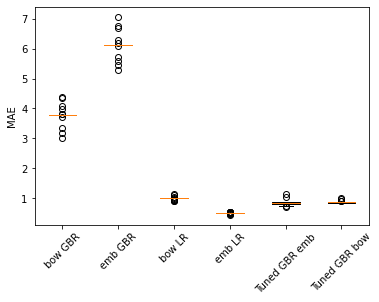

[CV] END learning_rate=0.001, num_base_estimators=5, subsampling_of_rows=False; total time=   1.5s
[CV] END learning_rate=0.001, num_base_estimators=10, subsampling_of_rows=False; total time=   3.1s
[CV] END learning_rate=0.001, num_base_estimators=15, subsampling_of_rows=True; total time=   2.1s
[CV] END learning_rate=0.001, num_base_estimators=20, subsampling_of_rows=True; total time=   3.0s
[CV] END learning_rate=0.001, num_base_estimators=20, subsampling_of_rows=False; total time=   6.1s
[CV] END learning_rate=0.01, num_base_estimators=10, subsampling_of_rows=False; total time=   3.1s
[CV] END learning_rate=0.01, num_base_estimators=15, subsampling_of_rows=False; total time=   4.7s
[CV] END learning_rate=0.01, num_base_estimators=20, subsampling_of_rows=False; total time=   6.3s
[CV] END learning_rate=0.1, num_base_estimators=10, subsampling_of_rows=False; total time=   3.1s
[CV] END learning_rate=0.1, num_base_estimators=15, subsampling_of_rows=False; total time=   4.6s
[CV] END l

[CV] END learning_rate=0.001, num_base_estimators=5, subsampling_of_rows=False; total time=   1.5s
[CV] END learning_rate=0.001, num_base_estimators=10, subsampling_of_rows=True; total time=   1.4s
[CV] END learning_rate=0.001, num_base_estimators=15, subsampling_of_rows=True; total time=   2.1s
[CV] END learning_rate=0.001, num_base_estimators=15, subsampling_of_rows=False; total time=   4.7s
[CV] END learning_rate=0.001, num_base_estimators=20, subsampling_of_rows=False; total time=   6.1s
[CV] END learning_rate=0.01, num_base_estimators=10, subsampling_of_rows=False; total time=   3.0s
[CV] END learning_rate=0.01, num_base_estimators=15, subsampling_of_rows=False; total time=   4.5s
[CV] END learning_rate=0.01, num_base_estimators=20, subsampling_of_rows=True; total time=   2.9s
[CV] END learning_rate=0.1, num_base_estimators=5, subsampling_of_rows=False; total time=   1.5s
[CV] END learning_rate=0.1, num_base_estimators=5, subsampling_of_rows=False; total time=   1.5s
[CV] END lear

In [45]:
# Making a plot
bp = plot.boxplot(MAE_df) 

plot.ylabel('MAE')
plot.xticks([1, 2, 3, 4, 5, 6],
           MAE_df.columns,
           rotation=45)
# display the plot
plot.show()

## Task 6: Reflect on the Performance of the Different Models Evaluated

Write a short (no more than 300 words) reflection on the different models trained as part of this work. 

1. The GradientBoosting Regressor (GBR) model achieved **smaller** Mean Absolute Error (MAE) when it was trained on the bag of words (BOW) representation dataset. The model returned **higher MAE** when it was trained on the sentence embedding (EMB) representation dataset. Therefore, we learned that given different inpute features, the same machine learning (ML) model would have different performance.

2. Our baseline model, Linear Regressor (LR) model, has **better** performance on both BOW representation data and EMB representation data than the GBR model. Especially, the LR model achieved **the smallest MAE** on the EMB representation data among all the evaluated models in this assignment. It tells us that the complicated ML model does not always give better performance than some simple (or baseline) models. More complicated model does not stand for better model.

3. Hyperparameter Tuning process significantly improved the performance of the GBR model, because the evaluation metrics - Mean Absolute Error (MAE), **dropped significantly** after GridSearchCV function was executed. On both the BOW representation dataset and the EMB representation dataset, Hyperparameter Tuning achieved **smaller MAE**. It indicates that Hyperparameter Tuning process is quite necessary for searching the best hyperparameter of a ML model to achieve the best score. A ML model with default hyperparameters does not give good performance generally.

4. Tuning the GBR model on BOW representation data gives similar mean value of MAE with tuning the model on EMB representation data. On BOW data, the MAE values have smaller variance than tuning model on EMB data. Because the  GridSearchCV function is a gradient algorithm which tries to find the smallest training error globally, the performance of model on different input feature does not vary a lot.